In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time 
print(tf.__version__)
start = time.time()

2.7.0


In [2]:
train_dir = 'C:/Users/Frankie/Pictures/FYP/Powerlines/training'
validation_dir = 'C:/Users/Frankie/Pictures/FYP/Powerlines/validation'

print(train_dir)

BATCH_SIZE = 10
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
    
end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

C:/Users/Frankie/Pictures/FYP/Powerlines/training
Found 160 files belonging to 2 classes.
Found 52 files belonging to 2 classes.
1.15 seconds have passed since start


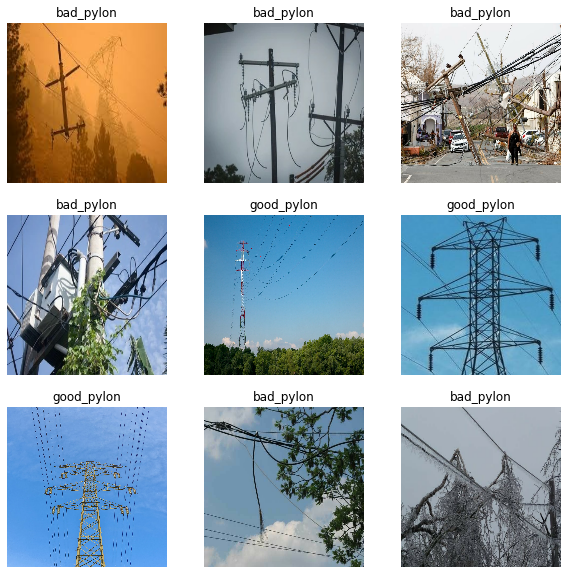

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 5
Number of test batches: 1


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

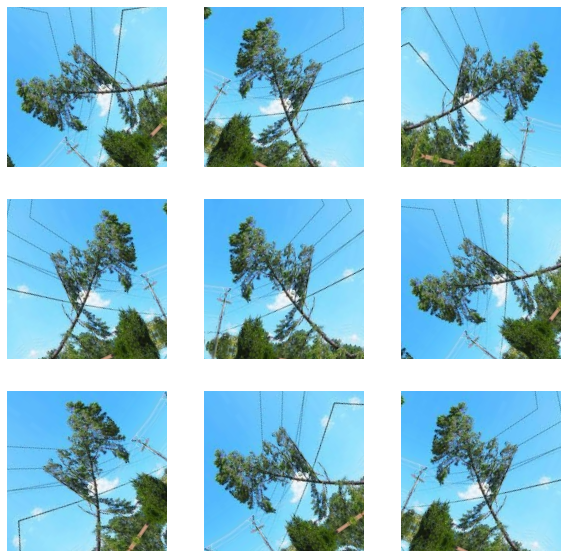

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [19]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

5/5 [==============================] - 2s 73ms/step - loss: 0.9526 - accuracy: 0.3571


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
    
end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

initial loss: 0.95
initial accuracy: 0.36
9.02 seconds have passed since start


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
    
end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

Epoch 1/20
16/16 [==============================] - 6s 184ms/step - loss: 0.6001 - accuracy: 0.6938 - val_loss: 1.0283 - val_accuracy: 0.7619
Epoch 2/20
16/16 [==============================] - 4s 181ms/step - loss: 0.3368 - accuracy: 0.8687 - val_loss: 0.7065 - val_accuracy: 0.8095
Epoch 3/20
16/16 [==============================] - 4s 184ms/step - loss: 0.2125 - accuracy: 0.9062 - val_loss: 1.0577 - val_accuracy: 0.7381
Epoch 4/20
16/16 [==============================] - 4s 183ms/step - loss: 0.2029 - accuracy: 0.9125 - val_loss: 1.0948 - val_accuracy: 0.7143
Epoch 5/20
16/16 [==============================] - 4s 182ms/step - loss: 0.1579 - accuracy: 0.9187 - val_loss: 0.8827 - val_accuracy: 0.7619
Epoch 6/20
16/16 [==============================] - 4s 181ms/step - loss: 0.1921 - accuracy: 0.9250 - val_loss: 1.5729 - val_accuracy: 0.6429
Epoch 7/20
16/16 [==============================] - 4s 183ms/step - loss: 0.1567 - accuracy: 0.9375 - val_loss: 1.4036 - val_accuracy: 0.6667
Epoch 

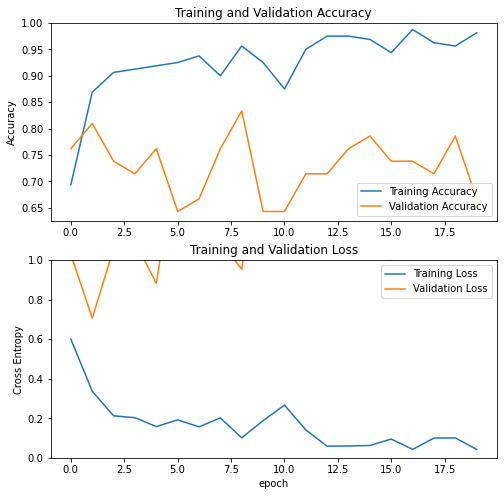

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [26]:
len(model.trainable_variables)    
end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

83.20 seconds have passed since start


In [27]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
    
end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

Epoch 20/40
16/16 [==============================] - 9s 279ms/step - loss: 5.6619 - accuracy: 0.5437 - val_loss: 0.8424 - val_accuracy: 0.5476
Epoch 21/40
16/16 [==============================] - 4s 233ms/step - loss: 1.6037 - accuracy: 0.5625 - val_loss: 0.6953 - val_accuracy: 0.4762
Epoch 22/40
16/16 [==============================] - 4s 234ms/step - loss: 2.0092 - accuracy: 0.4812 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 23/40
16/16 [==============================] - 4s 235ms/step - loss: 1.7718 - accuracy: 0.5250 - val_loss: 0.8780 - val_accuracy: 0.5476
Epoch 24/40
16/16 [==============================] - 4s 235ms/step - loss: 2.1171 - accuracy: 0.4625 - val_loss: 0.7238 - val_accuracy: 0.4762
Epoch 25/40
16/16 [==============================] - 4s 233ms/step - loss: 1.9095 - accuracy: 0.4563 - val_loss: 0.9398 - val_accuracy: 0.5238
Epoch 26/40
16/16 [==============================] - 4s 238ms/step - loss: 1.7614 - accuracy: 0.5312 - val_loss: 0.7004 - val_accuracy: 0.5000

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

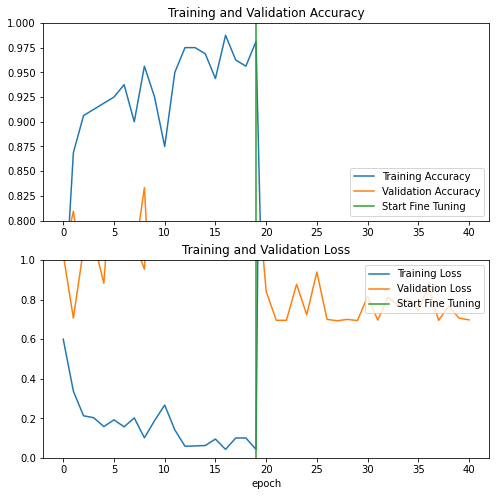

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 883ms/step - loss: 0.6830 - accuracy: 0.6000
Test accuracy : 0.6000000238418579


Predictions:
 [0 0 0 0 0 0 0 0 0 0]
Labels:
 [1 1 1 0 0 0 1 0 1 1]
183.45 seconds have passed since start


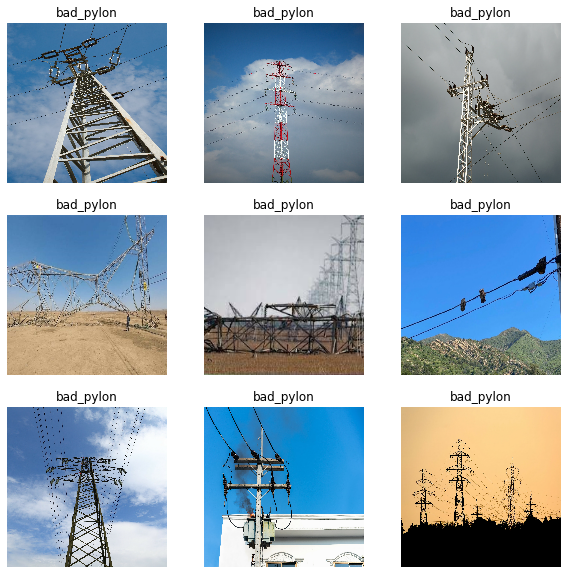

In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
    
end = time.time()
print("%.2f" % (end-start) + " seconds have passed since start")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
